## Authors
* Philippe Helal (260949246)
* Badreddine Sayah (260940022)

In [0]:
import cv2
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gym.spaces import Box
from IPython.display import clear_output
from torch import nn, optim

np.random.seed(1)
torch.manual_seed(1)


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class Env(gym.Wrapper):
    def __init__(self, game_name):
        env = gym.make(f"{game_name}NoFrameskip-v4")
        super().__init__(env)
        self.rep_memory = np.zeros((2, *env.observation_space.shape), np.uint8)
        self.lives = 0
        self.done = True
        self.observation_space = Box(0, 1, (1, 84, 84), np.uint8)

    def _reset(self, **kwargs):
        if self.done:
            self.env.reset(**kwargs)
            # Test evaluation method (<= 30 random no-ops)
            for _ in range(self.unwrapped.np_random.randint(1, 31)):
                s, _, done, _ = self.env.step(0)
                if done:
                    s = self.env.reset(**kwargs)
        else:
            done = self.done  # backup b/c step() overrides it
            s, _, _, _ = self.env.step(0)  # re-spawn back to life
            self.done = done

    def reset(self, **kwargs):
        self._reset(**kwargs)
        if "FIRE" in self.unwrapped.get_action_meanings():
            s, _, done, _ = self.step(1)  # Activate firing in environment
            if done:
                self._reset(**kwargs)
            s, _, done, _ = self.step(2)
            if done:
                self._reset(**kwargs)
        return s

    def step(self, a):
        reward = 0.0
        for i in range(4):
            s, r, done, info = self.env.step(a)
            if i in (2, 3):
                self.rep_memory[i - 2] = s
            reward += r
            if done:
                break
        s = self.rep_memory.max(0)

        self.done = done
        lives = self.env.unwrapped.ale.lives()
        done = 0 < lives < self.lives or done
        self.lives = lives
        r = np.sign(reward)  # clip to [-1, 1]
        return self.observation(s), r, done, info

    def observation(self, s):
        """As in Nature paper"""
        s = cv2.resize(cv2.cvtColor(s, cv2.COLOR_RGB2GRAY),
                       (84, 84), interpolation=cv2.INTER_AREA)[:, :, None]
        s = np.swapaxes(s, 2, 0)  # to feed into DQN
        return s

In [0]:
class DQN(nn.Module):

    """model architecture follows the paper
    Human-level control through deep reinforcement learning
    https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf"""

    def __init__(self, n_actions):
        super().__init__()
        self.n_actions = n_actions
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = self.net(x)
        return x

    def action_selection(self, s, epsilon):

        if epsilon >= np.random.random():
            a = np.random.choice(self.n_actions)
            return a
        # else:? TODO check
        with torch.no_grad():
            s = torch.tensor([s], dtype=torch.float32, device=DEVICE)
            Q_qnet = self(s)
            a = Q_qnet.argmax(1).item()
            return a


In [0]:
class PER:
    def __init__(self, N_transitions, k_batch, Alpha):
        """
        Priortized Experience Replay
        :param Alpha: float, factor that determines how much prioritization is applied
        :param N_transitions: prioritizing using a replay memory of n transitions (10^6)
        :param k_batch: n_samples
        
        """
        self.k_batch = k_batch
        self.N_transitions = N_transitions
        self.priorities = np.zeros(self.N_transitions, np.float32)
        self.i = 0 #  index
        self.rep_memory = list()
        self.Alpha = Alpha 
        

    def full_memory(self, memory_sz):
        """test if the replay buffer is full"""
        return (memory_sz >= self.N_transitions)


    def highest_priority(self, memory_sz):
        """get the hightest priority"""
        if memory_sz == 0:
            return  1
        elif memory_sz >= 1:
            return self.priorities.max() 

    def store(self, s, a, r, s_prime, done):
        """Store or add a transition to the Replay Memory"""
        
        s, s_prime = np.asarray([s]), np.asarray([s_prime])
        
        memory_sz = len(self.rep_memory)
        rep_memory_full = self.full_memory(memory_sz)

        if rep_memory_full == True:
            self.rep_memory[self.i] = (s, a, r, s_prime, done)
        else:
            self.rep_memory.append((s, a, r, s_prime, done))

        self.priorities[self.i] = self.highest_priority(memory_sz)

        self.i += 1  
        self.i %= self.N_transitions

    def replay(self, beta):
        """replaying transitions following probabilty of sampling transition i
        defined in equation (1) of the Prioritzed Experience Replay paper """
        memory_sz = len(self.rep_memory)

        if memory_sz != self.N_transitions:
            priorities = self.priorities[:self.i]
        else:
            priorities = self.priorities

        # Probabilities of sampling transitions
        probabilities = priorities ** self.Alpha
        probabilities = probabilities / probabilities.sum()

        idx = np.random.choice(a=memory_sz, 
                                   size=self.k_batch, 
                                   replace=True, 
                                   p=probabilities)
        
        # compute importance-sampling weights
        # from Algorithm 1 of PER paper
        W = 1 / ( probabilities[idx] * memory_sz ) ** beta
        W = W / W.max()

        S, A, R, S_prime, Done = zip(*(self.rep_memory[i] for i in idx))
        S, S_prime = map(np.concatenate, (S, S_prime))

        return S, A, R, S_prime, Done, W, idx,


In [0]:
def main(*game_names, alpha=0.6, n_transitions=10**5, k=32):
    cv2.ocl.setUseOpenCL(False)
    T = 700_000

    for game_name in game_names:
        env = Env(game_name)
        env.seed(1)

        # double DQN, primary network qnet
        qnet = DQN(env.action_space.n).to(DEVICE)
        # the target network
        tnet = DQN(env.action_space.n).to(DEVICE)
        optimizer = optim.Adam(qnet.parameters(), lr=0.0001)

        per = PER(N_transitions=n_transitions, k_batch=k, Alpha=alpha)
        tnet.load_state_dict(qnet.state_dict())  # Synchronize policies

        epsilon, k, gamma = 0.01, 32, 0.99
        rewards, reward, plot_rewards = list(), 0, list()

        s = env.reset()
        for t in range(1, T + 1):
            a = qnet.action_selection(s, epsilon)
            s_prime, r, done, _ = env.step(a)
            per.store(s, a, r, s_prime, done)
            s = s_prime
            reward += r
            if done:
                s = env.reset()
                rewards.append(reward)
                reward = 0
            if len(per.rep_memory) > (1e4):
                beta = min(1.0, 0.4 + t * 0.6 / (1e5) )  # Linear annealing
                # TD Loss
                S, A, R, S_prime, Done, W, idx = per.replay(beta)

                S = torch.tensor(S, dtype=torch.float32,
                                 requires_grad=True, device=DEVICE)
                S_prime = torch.tensor(
                    S_prime, dtype=torch.float32, requires_grad=True, device=DEVICE)
                A = torch.tensor(A, dtype=torch.long, device=DEVICE)
                R = torch.tensor(R, dtype=torch.long, device=DEVICE)
                Done = torch.tensor(Done, dtype=torch.long, device=DEVICE)
                W = torch.tensor(W, dtype=torch.long, device=DEVICE)
                Q_qnet = qnet(S).gather(1, A.unsqueeze(1)).squeeze(1)
                loss = (Q_qnet - (R + gamma * tnet(S_prime).max(1)
                                  [0] * (1 - Done)).detach()) ** 2 * W
                priorities = loss + 1e-5
                loss = loss.mean()
                optimizer.zero_grad()
                loss.backward()
                per.priorities[idx] = priorities.detach().cpu().numpy()
                optimizer.step()

            if t % (T / 200) == 0:
                plot_rewards.append(np.mean(rewards[-10:]))
                clear_output(True)
                plt.figure(figsize=(12,8))
                plt.plot(plot_rewards, 'g', linewidth=2, markersize=12)
        
                plt.title(game_name, fontsize=14)
                plt.xlabel(f"Training step / {T // 200}", fontsize=12)
                plt.ylabel("reward", fontsize=12)
                plt.legend(['Proportional']) if alpha!=0 else plt.legend(['Uniform'])

                plt.savefig(game_name + ".png")
                plt.show()

            if t % (T / 10) == 0:
                tnet.load_state_dict(qnet.state_dict())  # Synchronize policies

### Experiments Proportional Prioritized Experience Replay

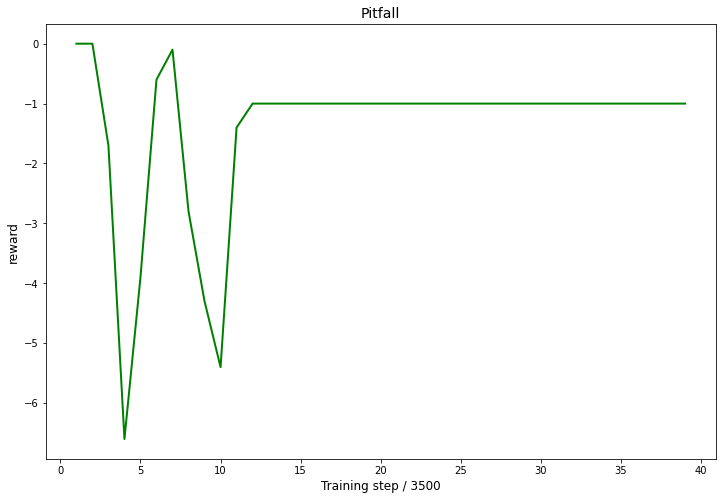

In [0]:
main("Pitfall")

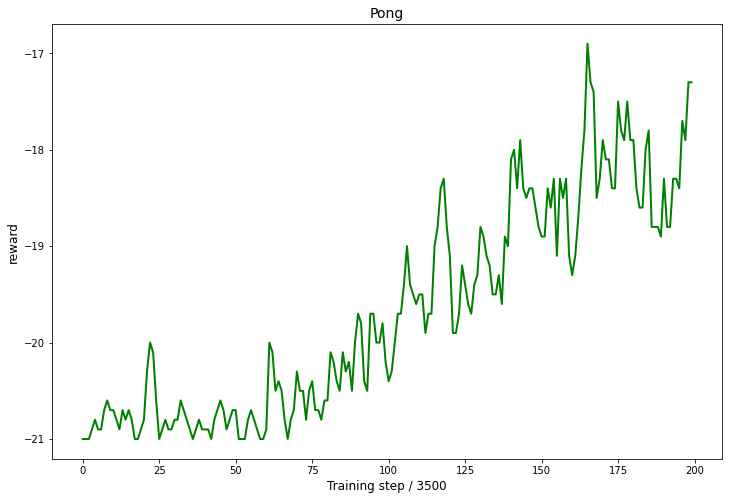

In [0]:
 main("Pong")

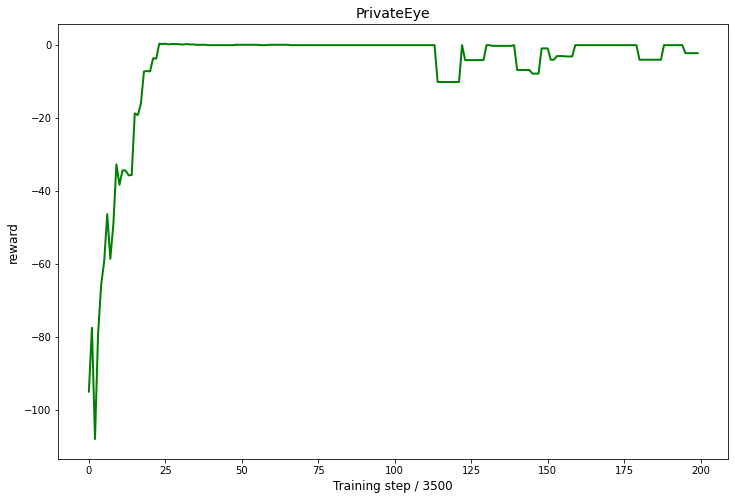

In [0]:
 main("PrivateEye")

### Uniform 

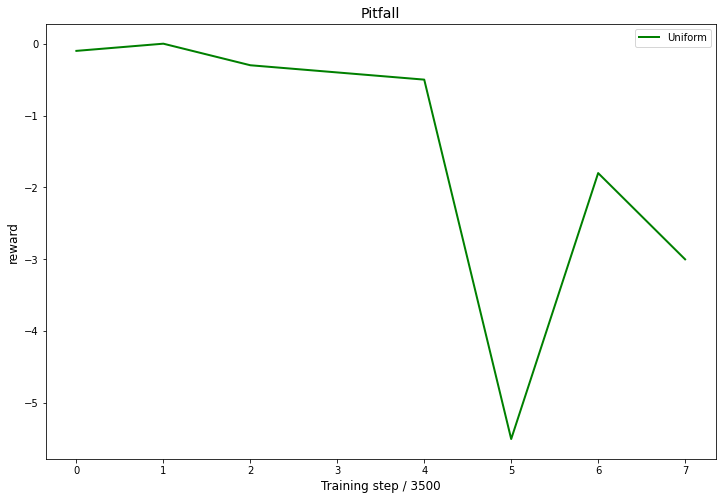

In [0]:
main("Pitfall", alpha=0.0,  n_transitions=10**5)